### Code done by Serden-Yilmaz Kose, Jesper Nyman and Jussi Saariniemi

In [2]:
import nltk
import numpy as np
from nltk.corpus import genesis
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [3]:
"""
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('genesis')

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
"""

"\nnltk.download('stopwords')\nnltk.download('punkt')\nnltk.download('wordnet')\nnltk.download('genesis')\n\nnltk.download('punkt_tab')\nnltk.download('averaged_perceptron_tagger_eng')\nnltk.download('averaged_perceptron_tagger')\nnltk.download('vader_lexicon')\n"

In [4]:
import pandas as pd

path = "./kurrek.2020.slur-corpus.csv"
data = pd.read_csv(path, sep=",", header = 0, on_bad_lines='skip')

In [5]:
# Make function to check if string contains any element from a string
# https://bobbyhadz.com/blog/python-check-if-string-contains-element-from-list
def is_element_in_string(string, flist):
    if any((match := substring) in string for substring in flist):
        print('The string contains at least one element from the list')
    return match

In [6]:
# Replace slur with [REDACTED], and print
# Make new data list using pandas
# This one is only to print the strings, to avoid printing harmful language. 

path = "./kurrek.2020.slur-corpus.csv"
redacted_data = pd.read_csv(path, sep=",", header = 0, on_bad_lines='skip')

# Iterate for each index in redacted_data, and modify the 'body' to replace the 
# slur with [REDACTED]. The indexes will remain the same as the one found in the original
# document, so this is really to just print out certain rows whilst avoiding printing out the
# harmful language (the slurs).
for index, row in redacted_data.iterrows():
    T1, T2 = str(row['body']), str(row['slur'])
    redacted_data.at[index, 'body'] = T1.lower().replace(T2, "[REDACTED]")

## Task 1

In [7]:
"""By constructing a dataframe of posts assigned to the same category, suggest a script that outputs the
vocabulary set of each category, the size of the vocabulary, the total number of tokens, the average
number of tokens per post and its standard deviation, the average number of pronouns per post and the
associated standard deviation, the ten most frequent tokens in each category, excluding the stopword list.
Represent the statistical result in a clear table and discuss whether some parameters are most relevant to
discriminate a given category."""

'By constructing a dataframe of posts assigned to the same category, suggest a script that outputs the\nvocabulary set of each category, the size of the vocabulary, the total number of tokens, the average\nnumber of tokens per post and its standard deviation, the average number of pronouns per post and the\nassociated standard deviation, the ten most frequent tokens in each category, excluding the stopword list.\nRepresent the statistical result in a clear table and discuss whether some parameters are most relevant to\ndiscriminate a given category.'

In [8]:
# The following is a list of categories, and the number of frequencies
"""
DEG 	Derogatory 	20531
NDG 	Non Derogatory Non Appropriative 	16729
HOM 	Homonym 	1998
APR 	Appropriative 	553
CMP 	Noise 	189
"""
# Create dictionary variables to store data stored about each category
def dict_template():
    temp_dict = {"vocab_set"     : [],
                 "vocab_size"    : 0,
                 "total_tokens"  : 0,
                 "avg_tokens"    : 0,
                 "tokens_standev": 0,
                 "avg_pronouns"  : 0,
                 "prp_standev"   : 0,
                 "freq_words"    : [],
                 "all_words"     : [],
                 "entire_words"  : [] 
           }
    return temp_dict

deg_dict = dict_template()
ndg_dict = dict_template()
hom_dict = dict_template()
apr_dict = dict_template()
cmp_dict = dict_template()

categ_dict = {0: deg_dict,
              1: ndg_dict,
              2: hom_dict,
              3: apr_dict,
              4: cmp_dict
             }
categ_string_list = {0: "DEG",
                     1: "NDG",
                     2: "HOM",
                     3: "APR",
                     4: "CMP"
             }

In [9]:
# Function to find the vocabulary set per category 
# Flatten out list of lists for vocab set
# https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
# https://stackoverflow.com/questions/10677020/real-word-count-in-nltk
# https://www.geeksforgeeks.org/python-statistics-stdev/
# https://stackoverflow.com/questions/35086440/python-how-to-compute-the-top-x-most-frequently-used-words-in-an-nltk-corpus
import itertools
import statistics
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

Stopwords = set(upper_word.lower() for upper_word in nltk.corpus.stopwords.words('english'))
Stopwords.add("http")
Stopwords.add("https")

def find_vocab_set(categ):
    # Iterate each index
    tokenized_bodies = []
    total_tokens = 0
    total_bodies = 0
    size_of_doc = []
    pronouns_num_list = []
    total_pronouns = 0
    most_frequent_words = []
    for index, row in data.iterrows():
        # Create body and label integer and string
        body, label = str(row['body']), str(row['gold_label'])
        # Check if the label is deg, ndg, hom, apr, or cmp
        if label == categ_string_list[categ]:
            tokenized_body = tokenizer.tokenize(body.lower())
            # Print tokenized body
            tokenized_bodies.extend(tokenized_body)
            # Update total tokens
            total_tokens += len(tokenized_body)
            # Update size of docs list
            size_of_doc.append(len(tokenized_body))
            # Update pronounds list
            tmp_pronoun = extract_pronouns(body)
            pronouns_num_list.append(tmp_pronoun)
            # Update total pronounds count
            total_pronouns += tmp_pronoun
            # Update total bodies
            total_bodies += 1
    # Remove doubles
    categ_dict[categ]["vocab_set"] = list(set(tokenized_bodies))
    # Update vocab size
    categ_dict[categ]["vocab_size"] = len(categ_dict[categ]["vocab_set"])
    # Update total number of tokens
    categ_dict[categ]["total_tokens"] = total_tokens
    # Update avg tokens:
    categ_dict[categ]["avg_tokens"] = total_tokens / total_bodies
    # Update token standard deviation
    categ_dict[categ]["tokens_standev"] = statistics.stdev(size_of_doc)
    # Update avg pronouns
    categ_dict[categ]["avg_pronouns"] = total_pronouns / total_bodies
    # Update pronoun standard deviation
    categ_dict[categ]["prp_standev"] = statistics.stdev(pronouns_num_list)
    # Remove stopwords
    bodies_without_stopwords = [word.lower() for word in tokenized_bodies if word.isalpha() and word.lower() not in Stopwords]
    # Update frequent tokens, without stopwords
    most_frequent_words = FreqDist(bodies_without_stopwords)
    categ_dict[categ]["freq_words"] = most_frequent_words.most_common(10)
    categ_dict[categ]["all_words"] = most_frequent_words.most_common(categ_dict[categ]["vocab_size"])
    categ_dict[categ]["entire_words"] = FreqDist(tokenized_bodies).most_common(categ_dict[categ]["vocab_size"])

# Function to extract number of pronouns in a given string
def extract_pronouns(string):
    # Extract pronouns using pos_tag
    pos_list = nltk.pos_tag(word_tokenize(string))
    number_of_pronouns = 0
    # Run through every entry
    for pos in pos_list:
        if pos[1] == "PRP":
            number_of_pronouns += 1
    return number_of_pronouns
            
        
find_vocab_set(0)
find_vocab_set(1)
find_vocab_set(2)
find_vocab_set(3)
find_vocab_set(4)

In [10]:
# Print DataFrame without array values (Since they have more than one element)
# https://stackoverflow.com/questions/31433989/return-copy-of-dictionary-excluding-specified-keys

DataFrame_dict = {}

def without_keys(d, keys):
    return {k: v for k, v in d.items() if k not in keys}

for key, value in categ_dict.items():
    """
    print(f"Info regarding category    {categ_string_list[key]}:")
    print(f"Vocab size:                {value["vocab_size"]}")
    print(f"Total size:                {value["total_tokens"]}")
    print(f"Average tokens:            {value["avg_tokens"]["num_tokens"]:.2f}")
    print(f"Token standard dev:        {value["avg_tokens"]["standard_dev"]:.2f}")
    print(f"Average pronouns:          {value["avg_pronouns"]["num_tokens"]:.2f}")
    print(f"Pronoun standard dev:      {value["avg_pronouns"]["standard_dev"]:.2f}")
    print(f"Ten frequent words:        {value["freq_words"]}")
    print("\n")
    """
    DataFrame_dict[categ_string_list[key]] = without_keys(value, ["vocab_set", "freq_words","all_words", "entire_words"])
# Print dataframe using Pandas
print(pd.DataFrame(DataFrame_dict))

                          DEG            NDG            HOM           APR  \
vocab_size       27301.000000   23657.000000    8650.000000   3423.000000   
total_tokens    582949.000000  699427.000000  100625.000000  20541.000000   
avg_tokens          28.394983      41.814252      50.362863     37.144665   
tokens_standev      22.066936      26.020754      33.913776     25.543456   
avg_pronouns         2.314710       3.803133       3.738739      4.023508   
prp_standev          2.467201       3.206034       3.536321      3.473162   

                        CMP  
vocab_size      2244.000000  
total_tokens    5743.000000  
avg_tokens        30.386243  
tokens_standev    19.270858  
avg_pronouns       1.164021  
prp_standev        1.332721  


In [11]:
"""WE have gathered lots of data, and can notice interesting aspects of our findings. First of all, the DEG category
has the most words by far, followed, by NDG, HOM, APR, and finally CMP. However, HOM and NDG have more tokens per
document than the other categories. The lowest standard deviation for the tokens was found in the CMP and DEG 
category. The most pronouns per token were found in APR and NDG. It's respective lowest standardized deviation was 
found in the CMP and DEG categories."""

"WE have gathered lots of data, and can notice interesting aspects of our findings. First of all, the DEG category\nhas the most words by far, followed, by NDG, HOM, APR, and finally CMP. However, HOM and NDG have more tokens per\ndocument than the other categories. The lowest standard deviation for the tokens was found in the CMP and DEG \ncategory. The most pronouns per token were found in APR and NDG. It's respective lowest standardized deviation was \nfound in the CMP and DEG categories."

## Task 2

In [12]:
"""Suggest a script to draw and evaluate the zipf’s law fitting for the dataframe of each category, and
computing the corresponding R2 and adjusted R2 statistics."""

'Suggest a script to draw and evaluate the zipf’s law fitting for the dataframe of each category, and\ncomputing the corresponding R2 and adjusted R2 statistics.'

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from nltk import FreqDist
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
# https://www.geeksforgeeks.org/zipfs-law/#what-is-zipfs-law 
# https://www.geeksforgeeks.org/r-squared-vs-adjusted-r-squared-difference/
# https://www.statology.org/r-squared-in-python/
# https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
# https://www.statology.org/adjusted-r-squared-in-python/

# Make dict to determine if function handles entire words, or all words(without stopwords)
freq_type_dict = {0: "entire_words",
                  1: "all_words"}

def zipfs_law_fitting_nltk(categ_dict, corpus_type):
    if corpus_type == 0:
        print("FOLLOWING DATA INCLUDES STOPWORDS!!!\n")
    else:
        print("FOLLOWING DATA EXCLUDES STOPWORDS!!!\n")
    for key, value in categ_dict.items():
        entire_words = value[freq_type_dict[corpus_type]]
        #Define two lists, rank and frequency
        rank = []
        frequency = []
        init = 0
        
        #Assign ranks based on frequencies of words
        for freq in entire_words:
            init+=1
            rank.append(init)
            frequency.append(freq[1])
        
        #Plot the rank and frequency
        plt.plot(np.log(rank),np.log(frequency))
        # Labelling the x axis
        plt.xlabel('Rank')
        # Labelling the y axis
        plt.ylabel('Frequency')
        
        # Providing a title to the graph
        plt.title(f"Zipf's law for {categ_string_list[key]}")

        # Getting r2 and adjusted r2 values
        #initiate linear regression model
        model = LinearRegression()

        X = np.array(rank).reshape(-1, 1)
        Y = frequency

        #fit regression model
        model.fit(X, Y)
        
        # Calculate R-squared of regression model
        log_ranks = np.log(rank)
        log_frequencies = np.log(frequency)
        slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_frequencies)
        r2 = r_value ** 2

        #display adjusted R-squared
        N = len(log_frequencies)
        r2_adjusted = 1 - ((1-r2)*(N - 1))/(N-1-1)
        
        # View R-squared value and adjusted
        print(f"R2 value for {categ_string_list[key]}         : {r2}")
        print(f"R2 adjusted value for {categ_string_list[key]}: {r2_adjusted}")


        # show linear regression
        log_ranks = np.log(rank)
        log_frequencies = np.log(frequency)
        slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_frequencies)
        plt.plot(log_ranks, slope * log_ranks + intercept, color='red', label=f'Fit: slope={slope:.2f}')
        
        # Show graph, after printing R2 and R2A 
        plt.show()

FOLLOWING DATA INCLUDES STOPWORDS!!!

R2 value for DEG         : 0.9757933758970119
R2 adjusted value for DEG: 0.9757924891750036


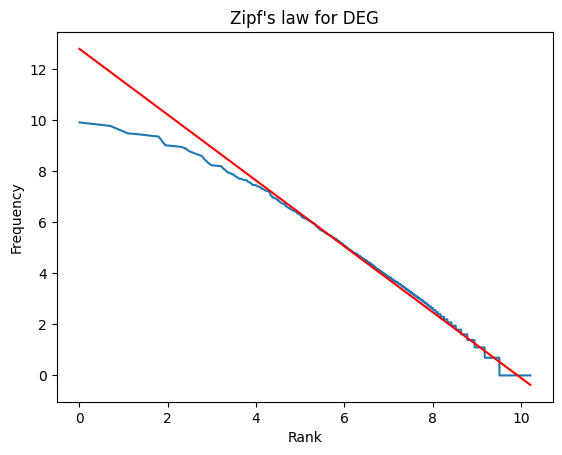

R2 value for NDG         : 0.9787002399552838
R2 adjusted value for NDG: 0.978699339521547


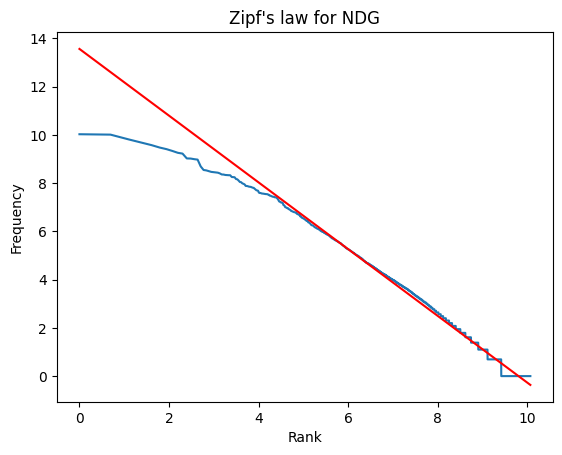

R2 value for HOM         : 0.971119650019415
R2 adjusted value for HOM: 0.9711163104784829


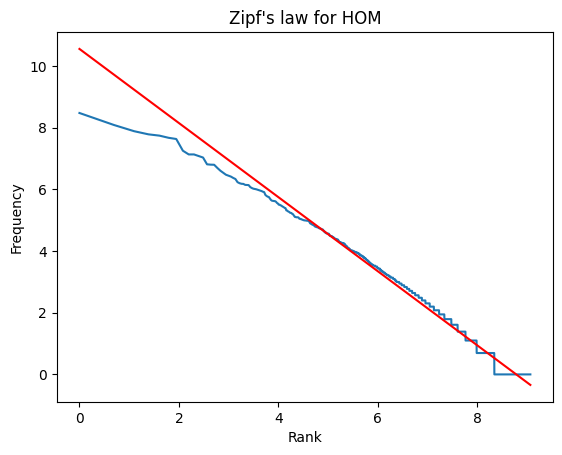

R2 value for APR         : 0.9554913773711744
R2 adjusted value for APR: 0.9554783669582457


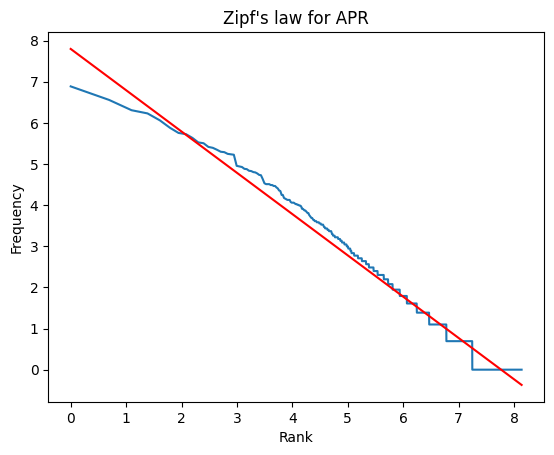

R2 value for CMP         : 0.9012812734447473
R2 adjusted value for CMP: 0.9012372418985585


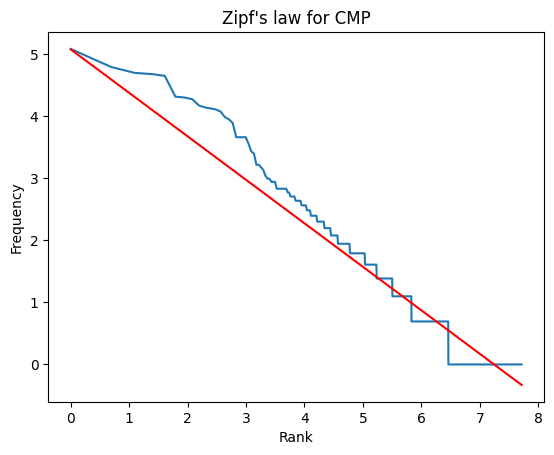

In [14]:
zipfs_law_fitting_nltk(categ_dict, 0)

## Task 3

FOLLOWING DATA EXCLUDES STOPWORDS!!!

R2 value for DEG         : 0.971243821387232
R2 adjusted value for DEG: 0.9712426977478676


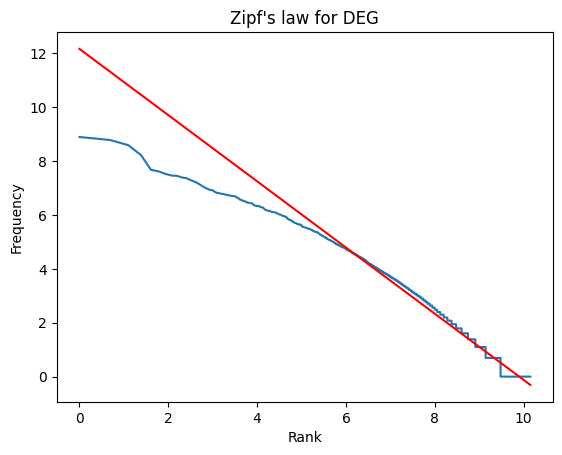

R2 value for NDG         : 0.97314190475247
R2 adjusted value for NDG: 0.9731406980267097


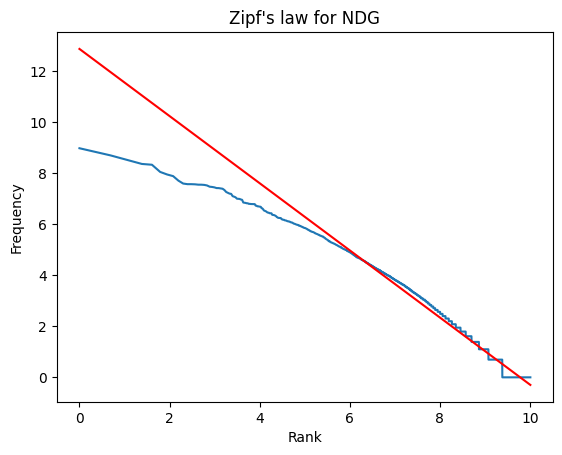

R2 value for HOM         : 0.9582418050678706
R2 adjusted value for HOM: 0.9582362909790112


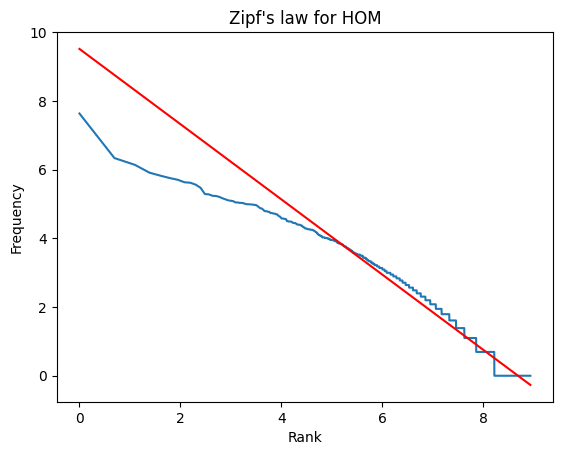

R2 value for APR         : 0.945773310118242
R2 adjusted value for APR: 0.9457564118041623


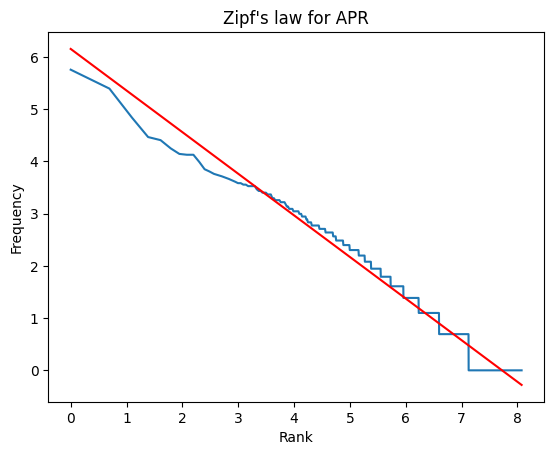

R2 value for CMP         : 0.8873244487066193
R2 adjusted value for CMP: 0.8872636744071083


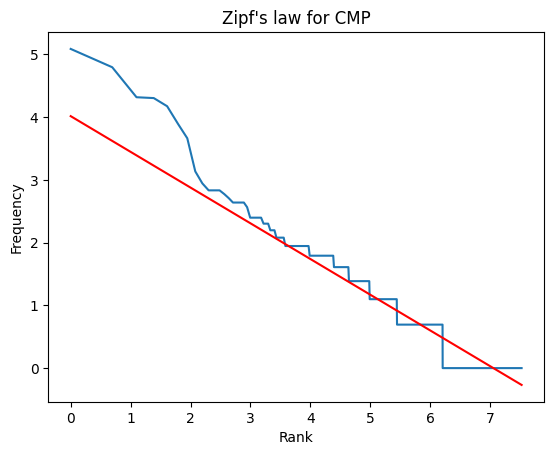

In [15]:
zipfs_law_fitting_nltk(categ_dict, 1)

## Task 4

In [16]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

data = pd.DataFrame(data)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jesper\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jesper\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# bodies contained values that were not strings, so we had to convert them to strings
data['body'] = data['body'].apply(lambda x: str(x) if not isinstance(x, str) else x)      

In [18]:
# tokenizing and lowering each body and then pos tagging them
pos_tagged = []
for body in data["body"]:
    tokens = word_tokenize(body.lower())
    tokens = [word for word in tokens if word.isalnum()]
    pos_tagged.append(nltk.pos_tag(tokens))

In [19]:
# counting the amount of each pos tag and sorting them from most frequent to least frequent
pos_amounts = {}
for pos in pos_tagged:
    for word, tag in pos:
        if tag in pos_amounts:
            pos_amounts[tag] += 1
        else:
            pos_amounts[tag] = 1

pos_amounts = dict(sorted(pos_amounts.items(), key=lambda item: item[1], reverse=True))

print(pos_amounts)

{'NN': 254159, 'IN': 138739, 'DT': 129163, 'JJ': 112122, 'PRP': 89823, 'RB': 85834, 'VB': 69072, 'NNS': 68889, 'VBP': 59405, 'VBD': 44681, 'VBZ': 43978, 'CC': 43789, 'VBG': 37805, 'TO': 31827, 'PRP$': 22995, 'VBN': 22758, 'MD': 17823, 'CD': 11805, 'WRB': 11448, 'WP': 9525, 'RP': 8448, 'WDT': 5789, 'JJR': 5282, 'JJS': 2773, 'EX': 2730, 'RBR': 2173, 'PDT': 1757, 'RBS': 690, 'UH': 431, 'FW': 399, 'NNP': 235, 'WP$': 58, '$': 33, 'NNPS': 31, "''": 15, 'POS': 1, 'LS': 1}


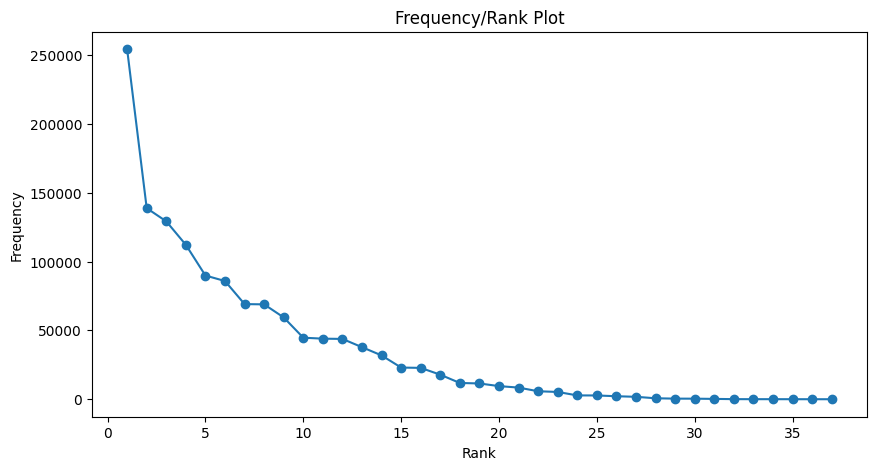

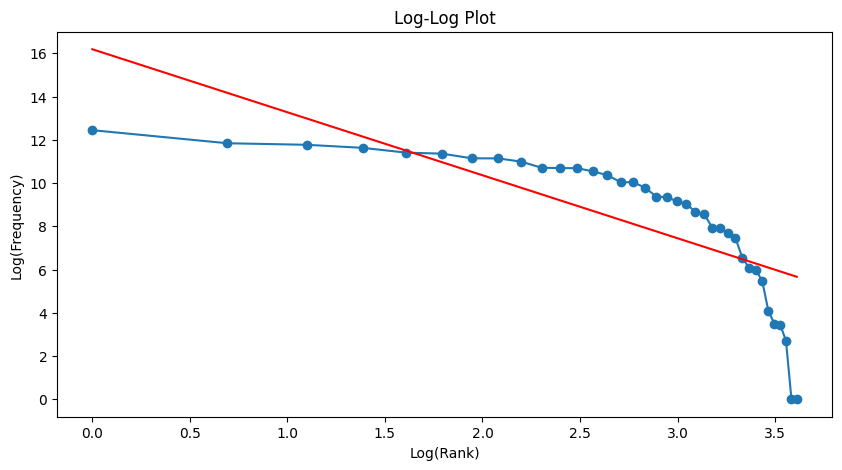

R-squared: 0.5898198040003063
Slope: -2.914832547567965
P value: 2.8884983114776053e-08
There is some resemblance to Zipfs law, but not enough.


In [20]:
# Checking if Zipfs law distribution can be fitted for the frequencies of pos tags across all the bodies

from scipy.stats import linregress

frequencies = list(pos_amounts.values())
ranks = range(1, len(pos_amounts) + 1)

plt.figure(figsize=(10, 5))
plt.plot(ranks, frequencies, marker='o')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Frequency/Rank Plot')
plt.show()

log_ranks = np.log(ranks)
log_frequencies = np.log(frequencies)

plt.figure(figsize=(10, 5))
plt.plot(log_ranks, log_frequencies, marker='o')

slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_frequencies)
plt.plot(log_ranks, slope * log_ranks + intercept, color='red', label=f'Fit: slope={slope:.2f}')

plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.title('Log-Log Plot')

plt.show()

print(f"R-squared: {r_value ** 2}")
print(f"Slope: {slope}")
print(f"P value: {p_value}")

print("There is some resemblance to Zipfs law, but not enough.")

## Task 5

In [21]:
# Checking if Heaps law can be fitted for each category of bodies

# Extracting the bodies sorted by category into a dataframe
bodies_by_category = {}

for index, row in data.iterrows():
    # Create body and label integer and string
    body, label = str(row['body']), str(row['gold_label'])
    if label in bodies_by_category:
        bodies_by_category[label].append(body)
    else:
        bodies_by_category[label] = [body]

bodies_by_category = pd.DataFrame(bodies_by_category.items(), columns=['Category', 'Bodies'])

# preprocessing the bodies and storing them in a new dataframe
tokens_by_category = {}

for index, row in bodies_by_category.iterrows():
    bodies, label = row['Bodies'], row['Category']

    for body in bodies:
        tokens = word_tokenize(body.lower())
        tokens = [word for word in tokens if word.isalnum()]
        if label in tokens_by_category:
            tokens_by_category[label].extend(tokens)
        else:
            tokens_by_category[label] = []
            tokens_by_category[label] = tokens

tokens_by_category = pd.DataFrame(tokens_by_category.items(), columns=['Category', 'Tokens'])

In [22]:
def DataPointsCalculator(category):
    tokens = tokens_by_category[tokens_by_category['Category'] == category]['Tokens'].sum()
    points = []
    unique_tokens = []

    for i in range(1, len(tokens)):
        if tokens[i] not in unique_tokens:
            unique_tokens.append(tokens[i])
        points.append((i, len(unique_tokens)))

    return points

uniqueTokensByTotalTokens = {
    'DEG': DataPointsCalculator('DEG'),
    'NDG': DataPointsCalculator('NDG'),
    'HOM': DataPointsCalculator('HOM'),
    'APR': DataPointsCalculator('APR'),
    'CMP': DataPointsCalculator('CMP')
}

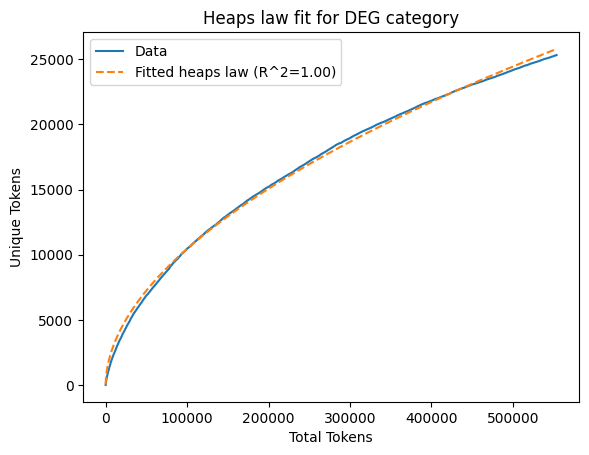

For DEG category with k=23.95 and b=0.53, the R^2 value is 1.00
Heaps law fit is good


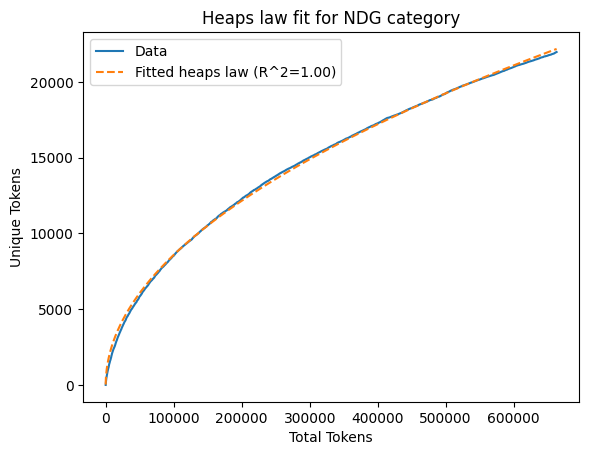

For NDG category with k=26.59 and b=0.50, the R^2 value is 1.00
Heaps law fit is good


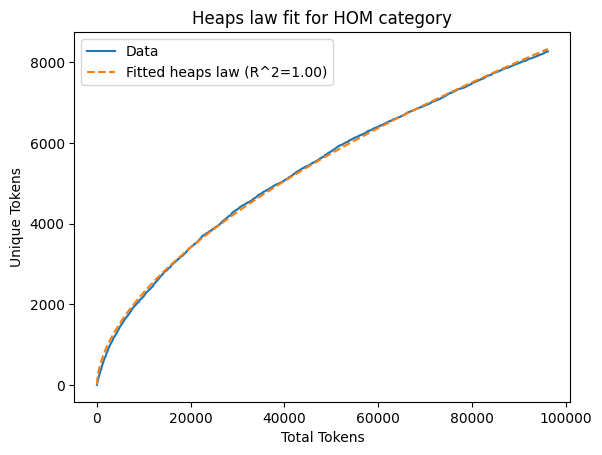

For HOM category with k=12.16 and b=0.57, the R^2 value is 1.00
Heaps law fit is good


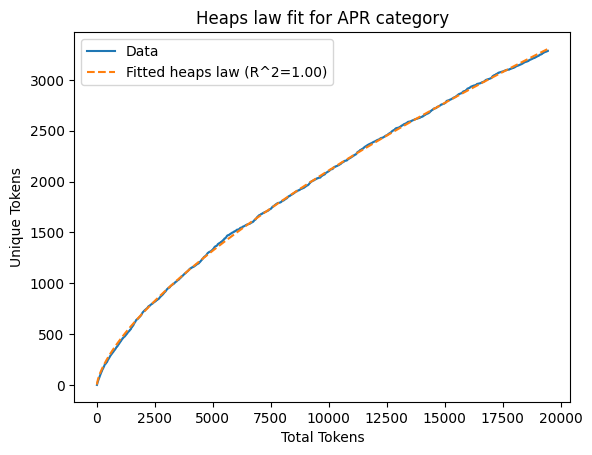

For APR category with k=4.23 and b=0.67, the R^2 value is 1.00
Heaps law fit is good


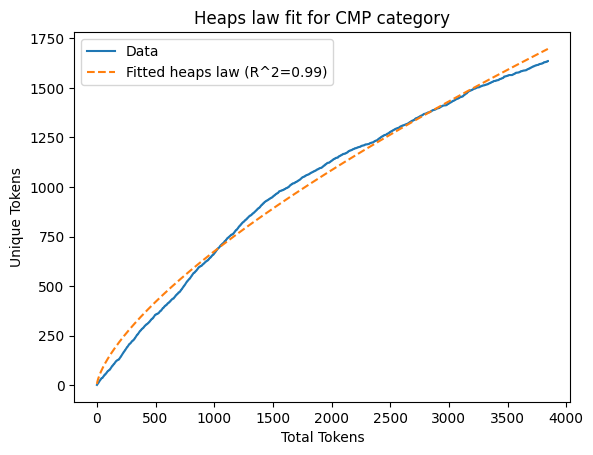

For CMP category with k=5.97 and b=0.68, the R^2 value is 0.99
Heaps law fit is good


In [23]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def HeapsLaw(N, k, b):
    return k * N ** b

heaps_fitting_results = {}

for row, points in uniqueTokensByTotalTokens.items():
    x_values, y_values = zip(*points)
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    popt, _ = curve_fit(HeapsLaw, x_values, y_values, maxfev=10000)
    k, b = popt
    
    y_pred = HeapsLaw(x_values, k, b)
    r2 = r2_score(y_values, y_pred)
    heaps_fitting_results[row] = {'k': k, 'beta': b, 'R2': r2}
    
    plt.plot(x_values, y_values, label='Data')
    plt.plot(x_values, y_pred, label=f'Fitted heaps law (R^2={r2:.2f})', linestyle='--')
    
    plt.xlabel('Total Tokens')
    plt.ylabel('Unique Tokens')
    plt.title(f'Heaps law fit for {row} category')
    plt.legend()
    plt.show()

    print(f"For {row} category with k={k:.2f} and b={b:.2f}, the R^2 value is {r2:.2f}")
    if r2 > 0.9:
        print("Heaps law fit is good")
    else:
        print("Heaps law fit is not good")
        


## Task 6

In [24]:
# Vocabulary for each category

vocabularies_by_category = {}

for index, row in tokens_by_category.iterrows():
    categ = row['Category']
    tokens = row['Tokens']
    vocabulary = set(tokens)
    vocabularies_by_category[categ] = vocabulary

In [25]:
categories = ['DEG', 'NDG', 'HOM', 'APR', 'CMP']

# Jaccard similarity between the vocabularies of categories
jaccard_similarities = {}
for i in range(0, len(categories)):
    for j in range(i + 1, len(categories)):
        category1 = categories[i]
        category2 = categories[j]
        vocabulary1 = vocabularies_by_category[category1]
        vocabulary2 = vocabularies_by_category[category2]
        jaccard_similarity = len(vocabulary1.intersection(vocabulary2)) / len(vocabulary1.union(vocabulary2))
        jaccard_similarities[(category1, category2)] = jaccard_similarity

print("Jaccard similarity between the vocabularies of each category pair:")
for categories, similarity in jaccard_similarities.items():
    print(f"{categories[0]} and {categories[1]}: {similarity:.2f}")


Jaccard similarity between the vocabularies of each category pair:
DEG and NDG: 0.40
DEG and HOM: 0.19
DEG and APR: 0.11
DEG and CMP: 0.04
NDG and HOM: 0.21
NDG and APR: 0.13
NDG and CMP: 0.04
HOM and APR: 0.19
HOM and CMP: 0.08
APR and CMP: 0.14


## Task 7

In [26]:
# Each body in tokenized form by category
token_bodies_by_category = {}

for index, row in bodies_by_category.iterrows():
    categ = row['Category']
    bodies = row['Bodies']
    for body in bodies:

        tokens = word_tokenize(body.lower())
        tokens = [word for word in tokens if word.isalnum()]

        if categ in token_bodies_by_category:
            token_bodies_by_category[categ].append(tokens)
        else:
            token_bodies_by_category[categ] = []
            token_bodies_by_category[categ].append(tokens)

In [27]:
# pos tagging
pos_token_bodies_by_category = {}

for row, token_bodies in token_bodies_by_category.items():
    pos_token_bodies_by_category[row] = []
    for token_body in token_bodies:
        pos_token_bodies_by_category[row].append(nltk.pos_tag(token_body))

In [28]:
# Finding the pos tags for tokens around the modal verb with window size of 2

pos_tags_around_MD = {}

for row, pos_token_bodies in pos_token_bodies_by_category.items():
    pos_tags_around_MD[row] = []
    for body in pos_token_bodies:
        for i in range(0, len(body)):
            if body[i][1] == 'MD':
                start = max(i - 2, 0)
                end = min(i + 3, len(body))
                window = [token[1] for j, token in enumerate(body[start:end]) if (start + j) != i]
                pos_tags_around_MD[row].append(window)

In [29]:
# Counting the frequencies for all the pos tags around the MD by category
# and saving them in a dataframe
pos_tags_around_MD_frequencies = {}

for row, pos_token_list in pos_tags_around_MD.items():
    pos_tags_around_MD_frequencies[row] = {}
    for pos_tag_list in pos_token_list:
        for pos_tag in pos_tag_list:
            if pos_tag in pos_tags_around_MD_frequencies[row]:
                pos_tags_around_MD_frequencies[row][pos_tag] += 1
            else:
                pos_tags_around_MD_frequencies[row][pos_tag] = 1

# Cleanup for the dataframe
pos_tags_around_MD_frequencies = pd.DataFrame(pos_tags_around_MD_frequencies)
pos_tags_around_MD_frequencies = pos_tags_around_MD_frequencies.dropna(axis=1, how='all')
pos_tags_around_MD_frequencies = pos_tags_around_MD_frequencies.fillna(0)
pos_tags_around_MD_frequencies = pos_tags_around_MD_frequencies.astype(int)

In [30]:
print(pos_tags_around_MD_frequencies)

       DEG   NDG   HOM  CMP  APR
EX      54    68    15    0    2
RB    2258  2938   508   10   82
VB    7437  8586  1446   34  259
VBN    759   937   126    5   16
DT    1981  1967   472   10   69
NN    4427  4820   966   14  154
WP     267   285    24    0   11
IN    1699  2075   345    5   54
PRP   3538  4525   687   18  111
CC     708   977   188    2   19
JJS     48    50    12    1    4
NNS   1383  1558   169    8   42
RP     193   164    56    0    7
PRP$   384   351    56    0   19
VBD    182   267    23    2    3
JJ    1297  1626   280    8   48
VBP    359   477    55    3   17
CD     151   128    54    0   10
VBG    363   372    59    0   10
VBZ    163   195    19    2    7
WRB    373   492    39    3   14
MD      38    62    16    2    2
TO     265   336    46    4    8
JJR    100   138    20    1    3
PDT     14    11     3    0    0
WDT    210   269    58    1    8
RBR     29    35     4    0    1
UH       5     4     3    0    1
RBS      6     9     1    0    0
NNP      4

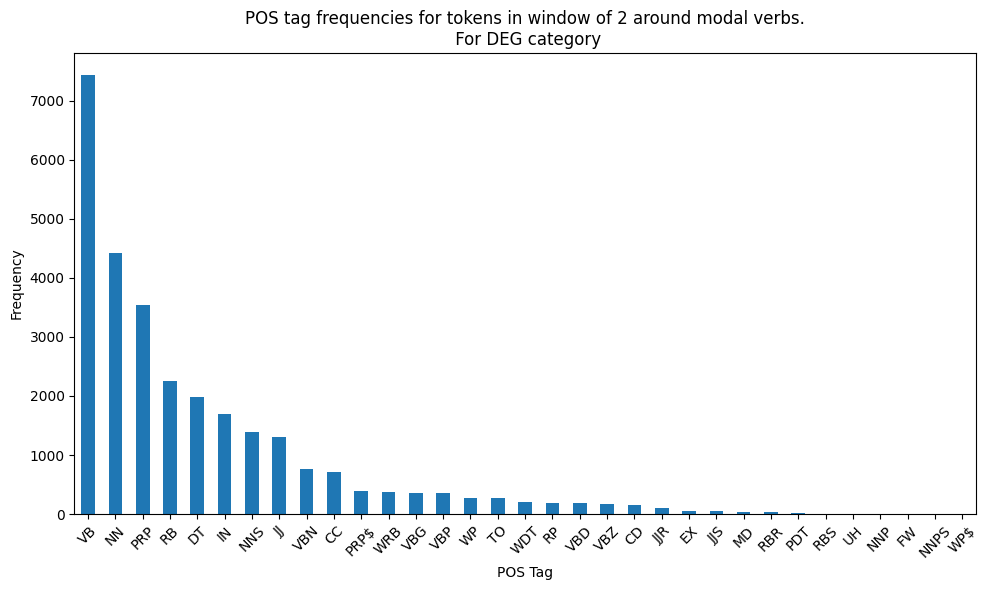

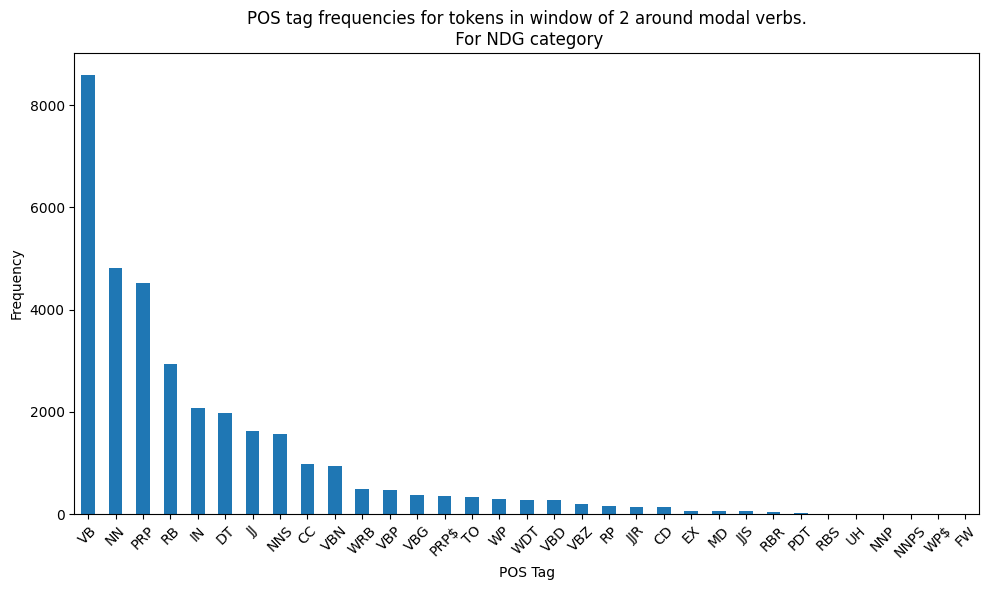

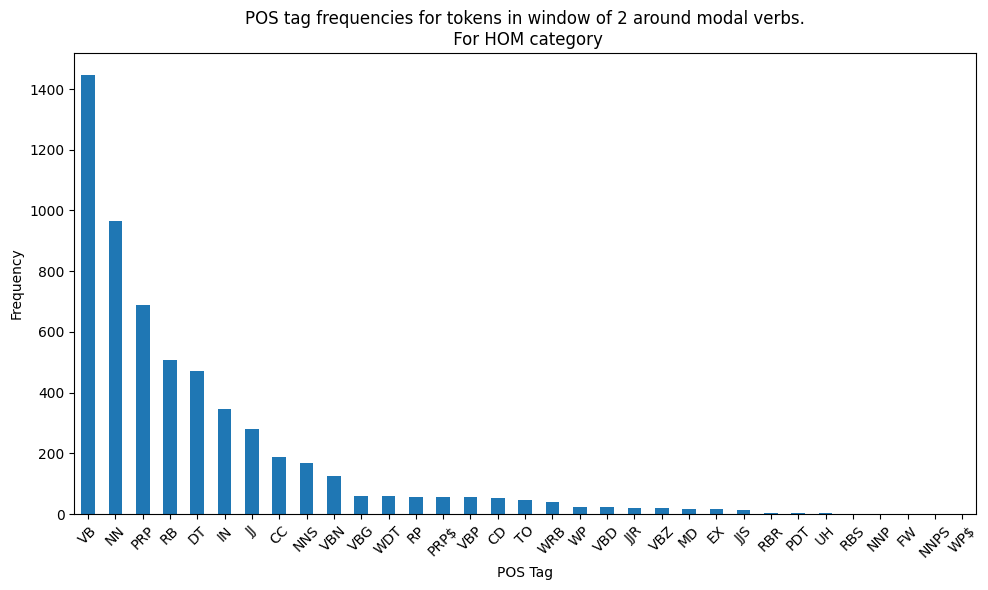

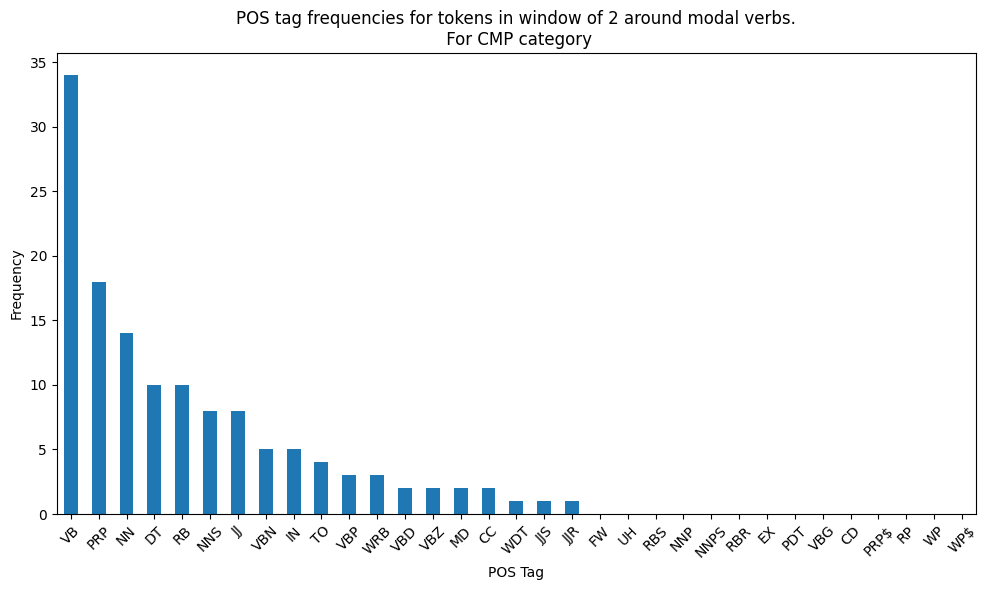

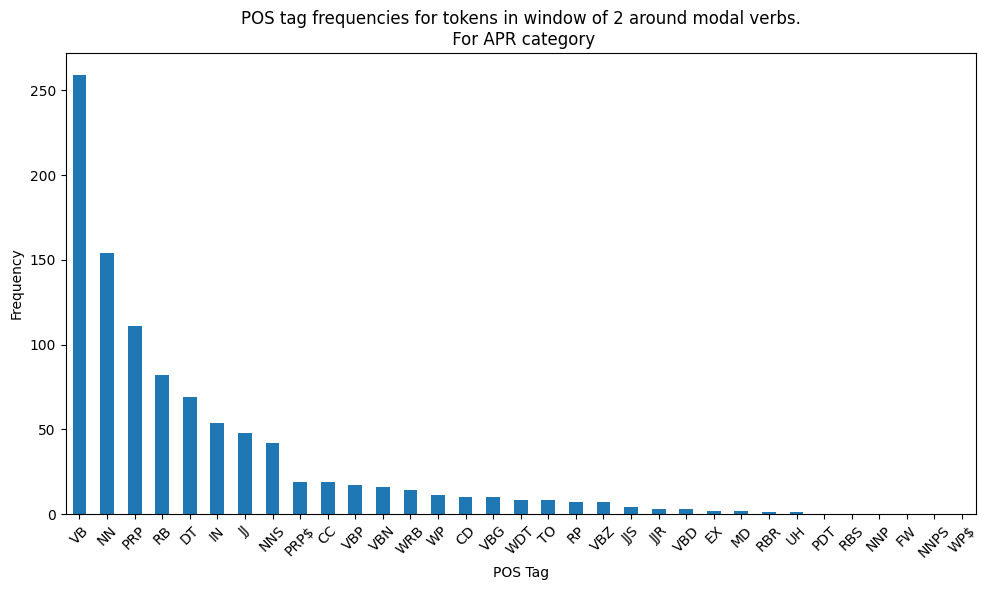

In [31]:
# plotting the frequencies of pos tags around the MD with window of 2 for each category
for row in pos_tags_around_MD_frequencies.columns:
    plt.figure(figsize=(10, 6))
    
    sorted_values = pos_tags_around_MD_frequencies[row].sort_values(ascending=False)
    
    sorted_values.plot(kind='bar')
    plt.title(f'POS tag frequencies for tokens in window of 2 around modal verbs.\n For {row} category')
    plt.xlabel('POS Tag')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [32]:
# Cosine similarity between pos tag frequencies of each pair of categories

from sklearn.metrics.pairwise import cosine_similarity

category_vectors = pos_tags_around_MD_frequencies.T

cosine_sim_matrix = pd.DataFrame(cosine_similarity(category_vectors), index=category_vectors.index, 
                                 columns=category_vectors.index)
print("Cosine similarity matrix between the frequencies of pos tags in a window of 2 around modal verbs")
print("for each category pair:")
print(cosine_sim_matrix)

print("\nAll the categories are quite similar to each other according to cosine similarity.")
print("This way of comparing similarity does not take into account the sample sizes.")
print("Small sample size can lead to misleading results.")
print("Smallest sample is CMP with 133, and largest is NDG with 33729, ")
print("so the similarity between NDG and CMP is not as reliable as the similarity between NDG and other large set like DEG.")

Cosine similarity matrix between the frequencies of pos tags in a window of 2 around modal verbs
for each category pair:
          DEG       NDG       HOM       CMP       APR
DEG  1.000000  0.997980  0.995674  0.979483  0.998181
NDG  0.997980  1.000000  0.992511  0.982733  0.994780
HOM  0.995674  0.992511  1.000000  0.967286  0.995415
CMP  0.979483  0.982733  0.967286  1.000000  0.975318
APR  0.998181  0.994780  0.995415  0.975318  1.000000

All the categories are quite similar to each other according to cosine similarity.
This way of comparing similarity does not take into account the sample sizes.
Small sample size can lead to misleading results.
Smallest sample is CMP with 133, and largest is NDG with 33729, 
so the similarity between NDG and CMP is not as reliable as the similarity between NDG and other large set like DEG.


## Task 8

In [33]:
"""Use Vader sentiment analysis package https://github.com/cjhutto/vaderSentiment to computer the
overall sentiment of each post, then draw a 10-bin histogram showing the proportion of posts whose
overall sentiment score falls in a given bin. This yields four histogram distributions (one histogram
distribution for each dataframe). Next, use the standard Euclidean histogram distance to compute the
similarity between every pair of categories with respect to sentiment scores."""

'Use Vader sentiment analysis package https://github.com/cjhutto/vaderSentiment to computer the\noverall sentiment of each post, then draw a 10-bin histogram showing the proportion of posts whose\noverall sentiment score falls in a given bin. This yields four histogram distributions (one histogram\ndistribution for each dataframe). Next, use the standard Euclidean histogram distance to compute the\nsimilarity between every pair of categories with respect to sentiment scores.'

In [35]:
# Import sentece and initialize analyzer 
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Creat dictionary to store sentiment values as a element of a list, as a value
sentiment_dict  = {  "DEG" : [],
                     "NDG" : [],
                     "HOM" : [],
                     "APR" : [],
                     "CMP" : []
             }

In [36]:
def find_vocab_sent(categ):
    for index, row in data.iterrows():
        # Create body and label integer and string
        body, label = str(row['body']), str(row['gold_label'])
        # Check if the label is deg, ndg, hom, apr, or cmp
        if label == categ_string_list[categ]:
            # Find sentiment score and append to respected category list
            vs = analyzer.polarity_scores(str(row['body']))
            sentiment_dict[categ_string_list[categ]].append(vs['compound'])
            #print("{:-<10} {}".format("", str(vs)))
find_vocab_sent(0)
find_vocab_sent(1)
find_vocab_sent(2)
find_vocab_sent(3)
find_vocab_sent(4)

In [37]:
import pprint
for key, value in sentiment_dict.items():
    print(f"Average sentiment for {key}: {sum(value) / len(value)}")

Average sentiment for DEG: -0.35102231855822263
Average sentiment for NDG: -0.40743375381121577
Average sentiment for HOM: 0.08847612612612624
Average sentiment for APR: -0.18029620253164547
Average sentiment for CMP: -0.11918095238095232


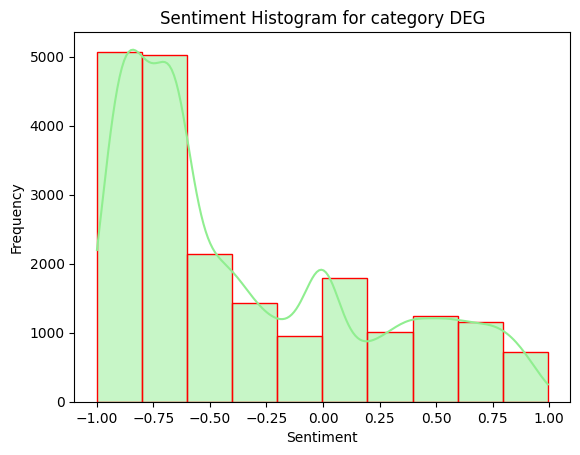

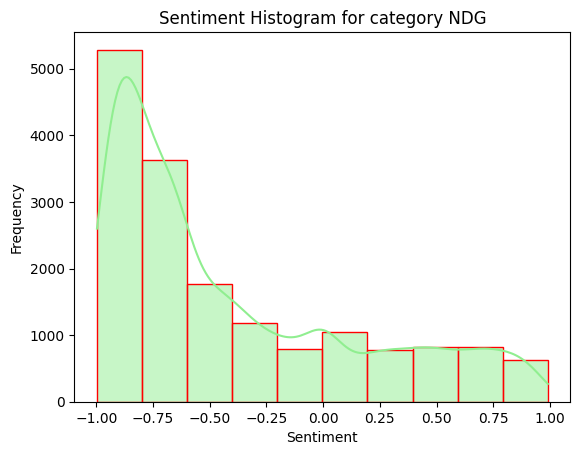

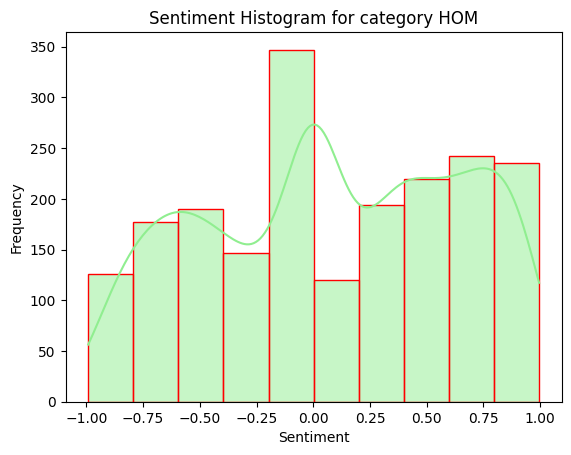

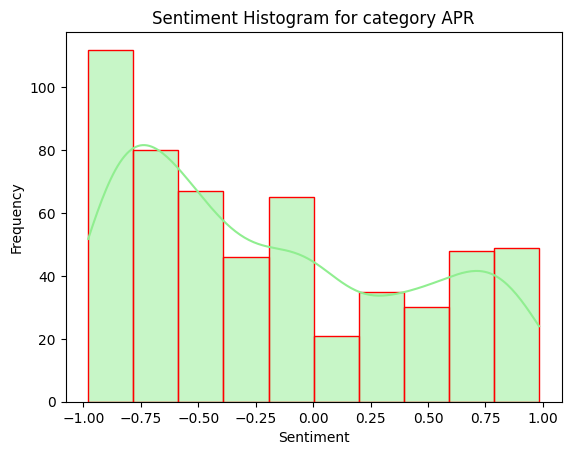

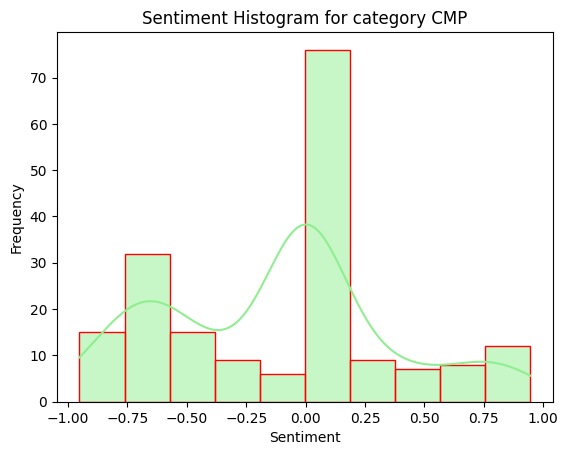

In [38]:
# Plotting histograms
# https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/
# https://stackoverflow.com/questions/20128898/get-data-points-from-a-histogram-in-python
import seaborn as sns

for key, value in sentiment_dict.items():
    sns.histplot(value, bins=10, kde=True, color='lightgreen', edgecolor='red')
    # Adding labels and title
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.title(f'Sentiment Histogram for category {key}')
     
    # Display the plot
    plt.show()

In [39]:
# Now iterate through each pair of categories, and find euclidian distance
# https://www.geeksforgeeks.org/calculate-the-euclidean-distance-using-numpy/
# https://stackoverflow.com/questions/9314576/calculate-distance-between-two-vectors-of-different-length
# First, we must fill the shorter lists with 0s
# Find largest list size
N = 0
for key, value in sentiment_dict.items():
    if len(value) > N:
        N = len(value)

# Now fill the smaller lists with 0s
# https://stackoverflow.com/questions/43336837/making-equal-size-lists-in-python
for key, value in sentiment_dict.items(): 
    if len(value) < N:
        value.extend([0] * (N-len(value)))

categories = ['DEG', 'NDG', 'HOM', 'APR', 'CMP']
for i in range(0, len(sentiment_dict.keys())):
    for j in range(i + 1, len(sentiment_dict.keys())):
        categ_1 = categories[i]
        categ_2 = categories[j]
        sent_1 = sentiment_dict[categ_1]
        sent_2 = sentiment_dict[categ_2]
        dist = np.linalg.norm(np.array(sent_1) - np.array(sent_2))
        print(f"Euclidian distance between {categ_1} and {categ_2}: {dist:.5f}")

Euclidian distance between DEG and NDG: 107.31409
Euclidian distance between DEG and HOM: 97.27318
Euclidian distance between DEG and APR: 93.98514
Euclidian distance between DEG and CMP: 93.29999
Euclidian distance between NDG and HOM: 92.48945
Euclidian distance between NDG and APR: 89.04923
Euclidian distance between NDG and CMP: 88.41161
Euclidian distance between HOM and APR: 29.75585
Euclidian distance between HOM and CMP: 26.04154
Euclidian distance between APR and CMP: 15.92110


## Task 9 (Creating categories in Empath library doesn't work)

In [40]:
# Removing the stopwords from the tokens since we dont need those for empath categorization
tokens_by_category_stopwords_removed = {}

for row in tokens_by_category.iterrows():
    category = row[1]['Category']
    tokens = row[1]['Tokens']
    tokens_by_category_stopwords_removed[category] = [word for word in tokens if word.lower() not in Stopwords]

# For some reason there was annoying NaN key in the dictionary, so this removes it
for key in tokens_by_category_stopwords_removed.keys():
    if pd.isna(key):
        tokens_by_category_stopwords_removed.pop(key)
        break

In [ ]:
# The empath library is broken in regards to creating new categories and has been for at least 2 years based on the issue tickets in github.
# The devopler has not answered to the issues. Last commit on github was 7 years ago.
# So this task 9. has to be skipped.

# When trying to create a new category it gives the following error:
# Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it

# Below is the code that would have been used to create the categories
# I also tried to create simpler category : "lexicon.create_category("animal", ["dog", "cat", "fish", "bird"])"
# but it gave the same error.
"""
from empath import Empath
lexicon = Empath()

for category, tokens in tokens_by_category_stopwords_removed.items():
    lexicon.create_category(category, tokens)
"""

## Task 10

In [48]:
from gensim.models import Doc2Vec

# Load the model
model_path = 'models/doc2vec.bin'
model = Doc2Vec.load(model_path)

# Calculate embeddings for each category
category_embeddings = {}

for category, tokens in tokens_by_category_stopwords_removed.items():
    token_vectors = [model.infer_vector(token) for token in tokens if token in model.wv]
    if token_vectors:
        category_embeddings[category] = np.mean(token_vectors, axis=0)
    else:
        category_embeddings[category] = np.zeros(model.vector_size)

# Calculate the cosine similarities
similarity_df = pd.DataFrame(index=category_embeddings.keys(), columns=category_embeddings.keys())

for category1, embedding1 in category_embeddings.items():
    for category2, embedding2 in category_embeddings.items():
        similarity = cosine_similarity([embedding1], [embedding2])[0][0]
        similarity_df.loc[category1, category2] = similarity

print(similarity_df)

AttributeError: Can't get attribute 'DocvecsArray' on <module 'gensim.models.doc2vec' from 'c:\\Python311\\Lib\\site-packages\\gensim\\models\\doc2vec.py'>

## Task 11

In [ ]:
"""We want to evaluate the various categories in terms of linguistic quality of the posts. For this purpose,
suggest a script to identify the number of unmatched tokens in each dataframe, for instance by seeking
whether the token has an entry in Wordnet. You may also inspire by some existing implementation such
as Spelling Correction Of The Text Data In Natural Language Processing | by Nutan | Medium. Estimate
the number of spelling errors in each category and its proportion with respect to the total number of
posts in the category."""

In [55]:
# Make function to run through all bodies of a specified category
# Create dictionary to hold how many errors are in each category
# https://medium.com/@nutanbhogendrasharma/spelling-correction-of-the-text-data-in-natural-language-processing-e9848407cf3b
from spellchecker import SpellChecker
spell = SpellChecker()

error_dict ={"DEG": 0,
             "NDG": 0,
             "HOM": 0,
             "APR": 0,
             "CMP": 0
             }
posts_dict ={"DEG": 0,
             "NDG": 0,
             "HOM": 0,
             "APR": 0,
             "CMP": 0
             }
def quality_analysis(categ):
    # Iterate each index
    for index, row in data.iterrows():
        # Create body and label integer and string
        body, label = str(row['body']), str(row['gold_label'])
        # If the label is the one we are looking for, continue
        if label == categ_string_list[categ]:
            # Print unknown, mispelt words
            # Remove punctuation as it seemingly affects the spellchecker
            #print(spell.unknown(body.split()))
            potential_error = spell.unknown(tokenizer.tokenize(body))
            # Update dictionary values
            error_dict[categ_string_list[categ]] += len(potential_error)
            posts_dict[categ_string_list[categ]] += 1
quality_analysis(0)
quality_analysis(1)
quality_analysis(2)
quality_analysis(3)
quality_analysis(4)

In [ ]:
# See the proportion of errors per post for each category
for key, value in error_dict.items():
    print(f"                 Potential errors in categ {key}: {value}")
    print(f"Proportion of errors per post for category {key}: {value/posts_dict[key]}")

In [ ]:
"""Here we can see the cateogry with the most potential spelling erros per post is CMP, and the category with the 
least potential spelling erros per post is DEG. This data may not be the best representation since there are far more
posts in DEG than CMP."""

## Task 12

{'DEG': [1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2

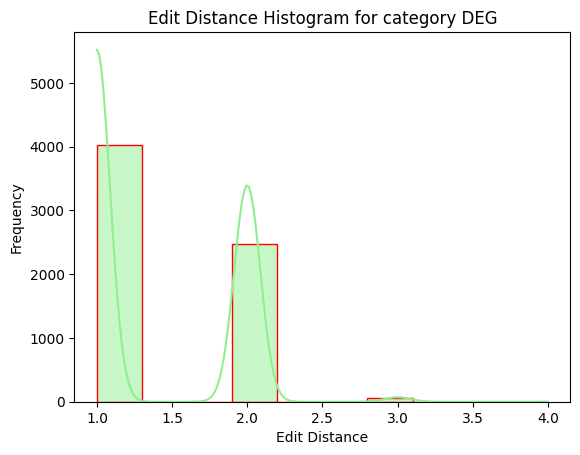

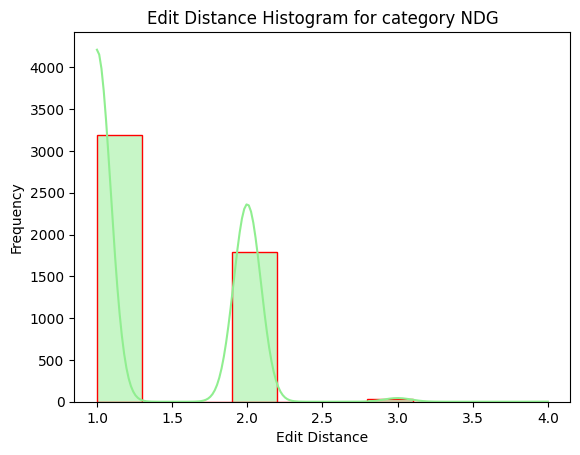

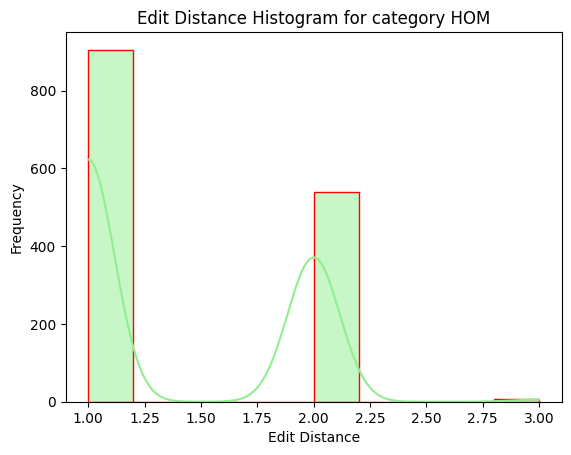

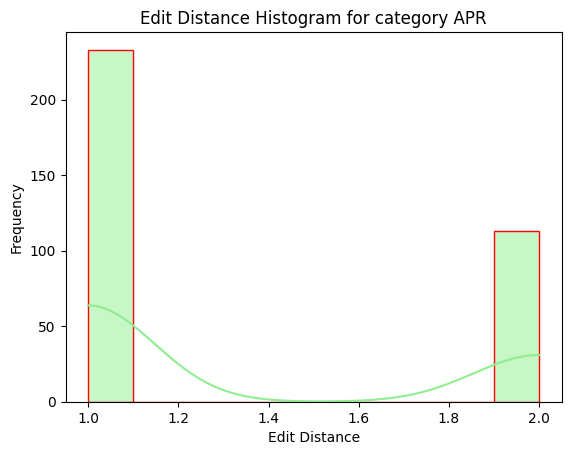

In [ ]:
from spellchecker import SpellChecker
from nltk.metrics import edit_distance
import os

spell = SpellChecker()

already_found = {}

# Function to find the closest correction and calculate edit distance
def find_corrections_and_distances(categ):
    corrections = []
    distances = []

    tokens = tokens_by_category_stopwords_removed[categ_string_list[categ]]
    
    misspelled = spell.unknown(tokens)
    
    for word in misspelled:
        if word in already_found.keys():
            correction = already_found[word]
        else:
            correction = spell.correction(word)
            if correction:
                already_found[word] = correction
        if correction:
            corrections.append((word, correction))
            distances.append(edit_distance(word, correction))

    print(f"Category: {categ_string_list[categ]}")
    
    return corrections, distances

# Dictionary to store corrections and distances for each category
corrections_dict = {}
distances_dict = {}

# Get corrections and distances for each category from files if they exist
if os.path.exists('corrections.csv') and os.path.exists('distances.csv'):
    with open('corrections.csv', 'r', encoding='utf-8') as f:
        current_category = None
        for line in f:
            line = line.strip()
            if ',' not in line:
                current_category = line
                corrections_dict[current_category] = []
            else:
                correction = line.split(',')
                corrections_dict[current_category].append((correction[0], correction[1]))
    with open('distances.csv', 'r', encoding='utf-8') as f:
        current_category = None
        for line in f:
            line = line.strip()
            if any(char.isalpha() for char in line):
                current_category = line
                distances_dict[current_category] = []
            else:
                distances_dict[current_category].append(int(line))
else:
    # Find corrections and distances for each category
    for i in range(len(categ_string_list)-1):
        corrections, distances = find_corrections_and_distances(i)
        corrections_dict[categ_string_list[i]] = corrections
        distances_dict[categ_string_list[i]] = distances

In [ ]:
# Save the corrections and distances to a file
if not os.path.exists('corrections.csv') and not os.path.exists('distances.csv'):
    with open('corrections.csv', 'w', encoding='utf-8') as f:
        for category, corrections in corrections_dict.items():
            f.write(f'{category}\n')
            for correction in corrections:
                f.write(f'{correction[0]},{correction[1]}\n')
    with open('distances.csv', 'w', encoding='utf-8') as f:
        for category, distances in distances_dict.items():
            f.write(f'{category}\n')
            for distance in distances:
                f.write(f'{distance}\n')

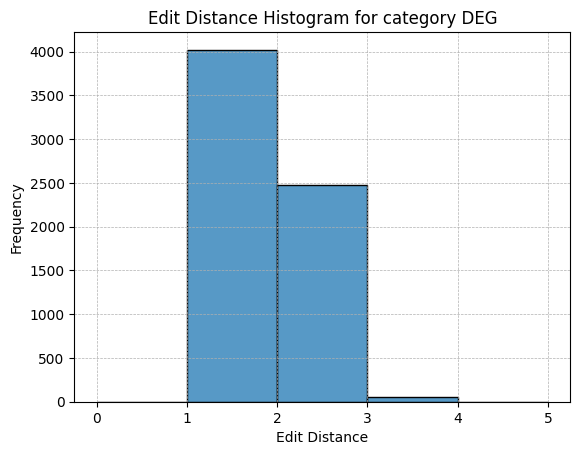

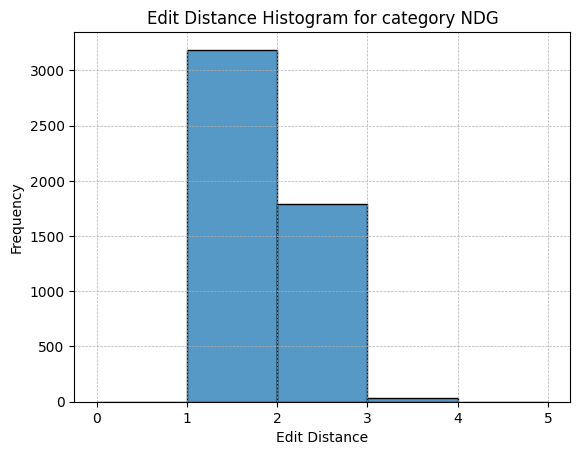

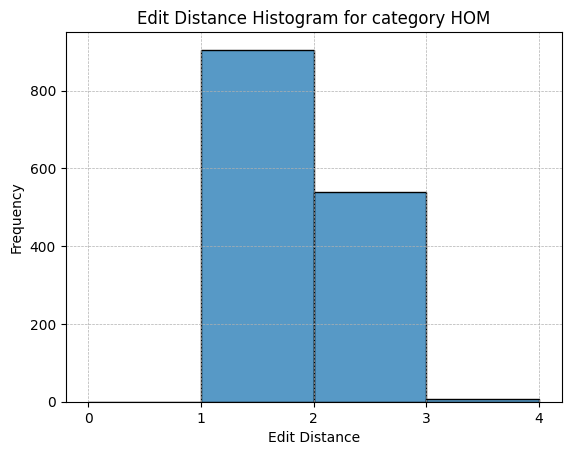

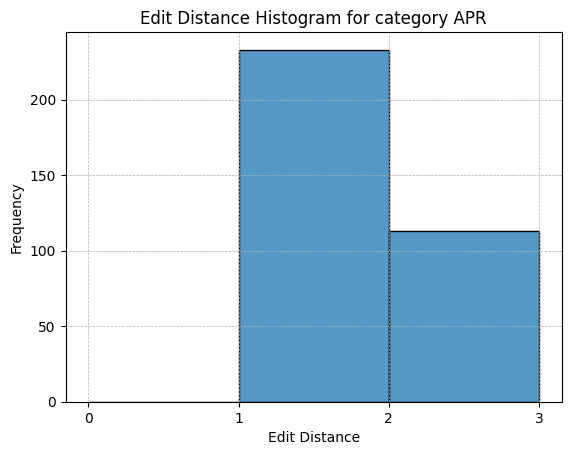

In [104]:
# Analyze edit distances by category by plotting a histogram
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

for category, distances in distances_dict.items():
    sns.histplot(distances, bins=range(0, max(distances) + 2), kde=False)
    
    # Set x-axis to only show integer ticks
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    
    # Add labels and title
    plt.xlabel('Edit Distance')
    plt.ylabel('Frequency')
    plt.title(f'Edit Distance Histogram for category {category}')
    
    # Add gridlines to improve readability
    plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5)
    
    # Show the plot
    plt.show()

In [105]:
# Print table of results
print("Edit distances by category:")
for category, distances in distances_dict.items():
    print(f"{category}:")
    print(f"Mean: {np.mean(distances):.2f}")
    print(f"Median: {np.median(distances)}")
    print(f"Standard deviation: {np.std(distances):.2f}")
    print()

Edit distances by category:
DEG:
Mean: 1.39
Median: 1.0
Standard deviation: 0.51

NDG:
Mean: 1.37
Median: 1.0
Standard deviation: 0.50

HOM:
Mean: 1.38
Median: 1.0
Standard deviation: 0.50

APR:
Mean: 1.33
Median: 1.0
Standard deviation: 0.47

